In [30]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from itertools import combinations
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm
import random

In [31]:
phase_dir = '../phased_ihart.ms2_quads_del'
ped_file = '../../DATA/ihart.ms2/ihart.ped'
assembly = '38'

#phase_dir = '../phased_spark_quads_del'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'
#assembly = '38'

#phase_dir = '../phased_ancestry_quads_del'
#ped_file = '../../DATA/ancestry/ancestry.ped.quads.ped'
#assembly = '38'

In [32]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	parents_to_children = defaultdict(list)
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
			if pieces[2] != '0' and pieces[3] != '0':
				parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
	return sample_to_affected, sample_to_sex, parents_to_children
sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped(ped_file)

In [33]:
sibpair_to_num_crossovers_mat = dict()
sibpair_to_num_crossovers_pat = dict()

sibpair_to_num_gcs_mat = dict()
sibpair_to_num_gcs_pat = dict()

mom_child_pairs = set()
dad_child_pairs = set()

# preferentially pull aut-aut and nt-nt sibpairs
for file in os.listdir(phase_dir):
    if file.endswith('.crossovers.json'):
        child1, child2 = file.split('.')[1:3]
            
        with open('%s/%s' % (phase_dir, file), 'r') as f:
            cos = json.load(f)

        with open('%s/%sgene_conversions.json' % (phase_dir, file[:-15]), 'r') as f:
            gcs = json.load(f)

        if len(cos)>0:
            assert (child1, child2) == tuple(cos[0]['child']) or (child2, child1) == tuple(cos[0]['child']) 
        if len(gcs)>0:
            assert (child1, child2) == tuple(gcs[0]['child']) or (child2, child1) == tuple(gcs[0]['child'])

        if len(cos)<200 and len(gcs)<200:
            sibpair_to_num_crossovers_mat[(child1, child2)] = len([x for x in cos if x['is_mat']])
            sibpair_to_num_crossovers_pat[(child1, child2)] = len([x for x in cos if x['is_pat']])
            sibpair_to_num_gcs_mat[(child1, child2)] = len([x for x in gcs if x['is_mat']])
            sibpair_to_num_gcs_pat[(child1, child2)] = len([x for x in gcs if x['is_pat']])

            mom_child_pairs.add((cos[0]['mom'], child1))
            mom_child_pairs.add((cos[0]['mom'], child2))
            dad_child_pairs.add((cos[0]['dad'], child1))
            dad_child_pairs.add((cos[0]['dad'], child2))
                
print(len(sibpair_to_num_crossovers_mat), len(sibpair_to_num_crossovers_pat), 
      len(sibpair_to_num_gcs_mat), len(sibpair_to_num_gcs_mat))

1967 1967 1967 1967


In [34]:
print(len([x for x in sibpair_to_num_gcs_mat.keys() if sample_to_affected[x[0]]=='1' and sample_to_affected[x[1]]=='1']))
print(len([x for x in sibpair_to_num_gcs_mat.keys() if sample_to_affected[x[0]]=='2' and sample_to_affected[x[1]]=='2']))
print(len([x for x in sibpair_to_num_gcs_mat.keys() if sample_to_affected[x[0]]!='1']))



57
1048
1474


In [35]:
# estimate the number of crossovers/gene conversion events for each child
child_to_num_crossovers_mat = dict()
child_to_num_crossovers_pat = dict()
child_to_num_gcs_mat = dict()
child_to_num_gcs_pat = dict()

for (mom, dad), children in parents_to_children.items():
    sibpairs = []
    siblings = set()
    for sib1, sib2 in combinations(children, 2):
        if (sib1, sib2) in sibpair_to_num_crossovers_mat:
            sibpairs.append((sib1, sib2))
            siblings.add(sib1)
            siblings.add(sib2)
        elif (sib2, sib1) in sibpair_to_num_crossovers_mat:
            sibpairs.append((sib2, sib1))
            siblings.add(sib1)
            siblings.add(sib2)
            
    siblings = sorted(siblings)
    
    if len(sibpairs)>= len(siblings) and len(siblings)>0:
        X = np.zeros((len(sibpairs), len(siblings)))
        y_mat_co = np.zeros((len(sibpairs),))
        y_pat_co = np.zeros((len(sibpairs),))
        y_mat_gc = np.zeros((len(sibpairs),))
        y_pat_gc = np.zeros((len(sibpairs),))
        for i, sibpair in enumerate(sibpairs):
            X[i, siblings.index(sibpair[0])] = 1
            X[i, siblings.index(sibpair[1])] = 1
            y_mat_co[i] = sibpair_to_num_crossovers_mat[sibpair]
            y_pat_co[i] = sibpair_to_num_crossovers_pat[sibpair]
            y_mat_gc[i] = sibpair_to_num_gcs_mat[sibpair]
            y_pat_gc[i] = sibpair_to_num_gcs_pat[sibpair]
                
            counts, _ = opt.nnls(X, y_mat_gc)
            for child, count in zip(siblings, counts):
                child_to_num_gcs_mat[child] = count
                
            counts, _ = opt.nnls(X, y_pat_gc)
            for child, count in zip(siblings, counts):
                child_to_num_gcs_pat[child] = count
                
            
        counts, _, _, _ = np.linalg.lstsq(X, np.hstack((y_mat_co[:, np.newaxis], y_pat_co[:, np.newaxis])))
        for child, count in zip(siblings, counts):
            child_to_num_crossovers_mat[child], child_to_num_crossovers_pat[child] = count
print(len(child_to_num_crossovers_mat))
print(len([x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='2']))
print(len([x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='1']))

1242
890
352


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [45]:
print(len(child_to_num_crossovers_mat), len(child_to_num_crossovers_pat))
print(sum(len(child_to_num_crossovers_mat)*stats.poisson.pmf(np.arange(100), 28)))

1242 1242
1241.9999999999995


41.00000000000001 42
27.499999999999993 28
75.24685461516427
20.147977682946248
40.49999999999999 42
27.916666666666647 28
74.37295310809128
18.525398350684487


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

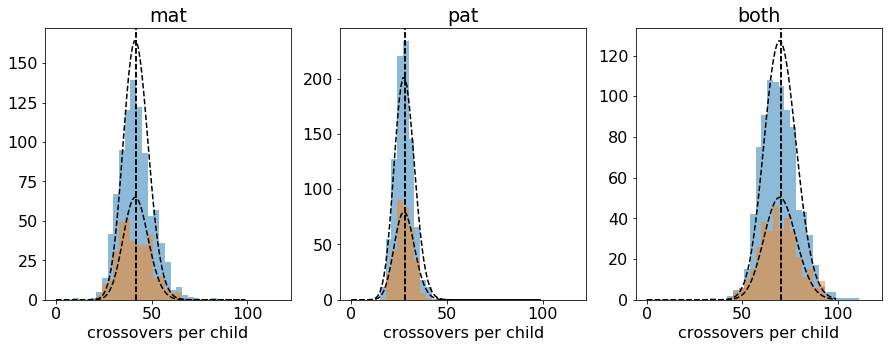

In [65]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 5))

for phen in ['2', '1']:
    children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]==phen]

    print(np.median([child_to_num_crossovers_mat[x] for x in children]), 42)
    print(np.median([child_to_num_crossovers_pat[x] for x in children]), 28)
    
    print(np.std([child_to_num_crossovers_mat[x] for x in children])**2)
    print(np.std([child_to_num_crossovers_pat[x] for x in children])**2)

    binsize = 3
    bins = np.arange(0, 120, binsize)

    plt.subplot(1, 3, 1)
    plt.hist(np.clip([child_to_num_crossovers_mat[x] for x in children], 0, 119), bins=bins, alpha=0.5, label='mat')
    plt.axvline(42, linestyle='--', color='black')
    plt.plot(np.arange(100), binsize*len(children)*stats.poisson.pmf(np.arange(100), 42), color='black', linestyle='--')
    plt.title('mat')
    plt.xlabel('crossovers per child')

    plt.subplot(1, 3, 2)
    plt.hist(np.clip([child_to_num_crossovers_pat[x] for x in children], 0, 119), bins=bins, alpha=0.5, label='pat')
    plt.axvline(28, linestyle='--', color='black')
    plt.plot(np.arange(100), binsize*len(children)*stats.poisson.pmf(np.arange(100), 28), color='black', linestyle='--')
    plt.title('pat')
    plt.xlabel('crossovers per child')

    plt.subplot(1, 3, 3)
    plt.hist(np.clip([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in children], 0, 119), 
             bins=bins, alpha=0.5, label='both')
    plt.axvline(42+28, linestyle='--', color='black')
    plt.plot(np.arange(100), binsize*len(children)*stats.poisson.pmf(np.arange(100), 42+28), color='black', linestyle='--')
    plt.title('both')
    plt.xlabel('crossovers per child')

plt.show()

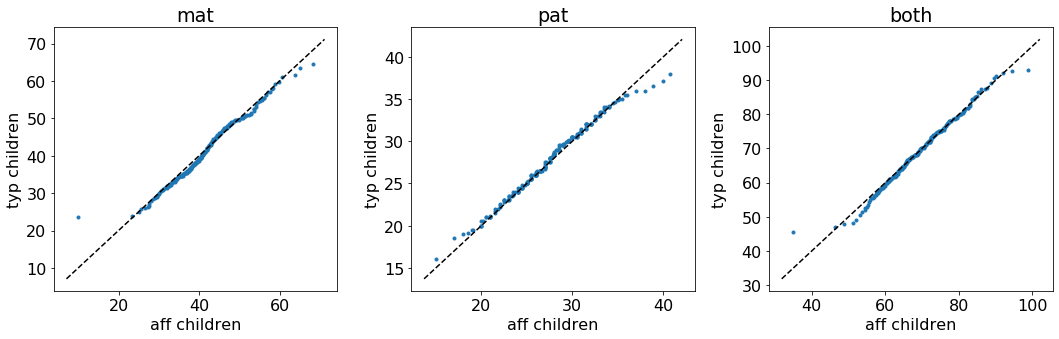

In [58]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15, 5))

aff_children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='2']
typ_children = [x for x in child_to_num_crossovers_mat.keys() if sample_to_affected[x]=='1']

bins = np.arange(0, 1, 0.005)

plt.subplot(1, 3, 1)
plt.scatter(np.quantile([child_to_num_crossovers_mat[x] for x in aff_children], bins), 
            np.quantile([child_to_num_crossovers_mat[x] for x in typ_children], bins),
            label='mat', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('mat')
plt.xlabel('aff children')
plt.ylabel('typ children')

plt.subplot(1, 3, 2)
plt.scatter(np.quantile([child_to_num_crossovers_pat[x] for x in aff_children], bins), 
            np.quantile([child_to_num_crossovers_pat[x] for x in typ_children], bins),
            label='pat', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('pat')
plt.xlabel('aff children')
plt.ylabel('typ children')

plt.subplot(1, 3, 3)
plt.scatter(np.quantile([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in aff_children], bins), 
            np.quantile([child_to_num_crossovers_mat[x]+child_to_num_crossovers_pat[x] for x in typ_children], bins),
            label='both', marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.title('both')
plt.xlabel('aff children')
plt.ylabel('typ children')

plt.tight_layout()
plt.show()

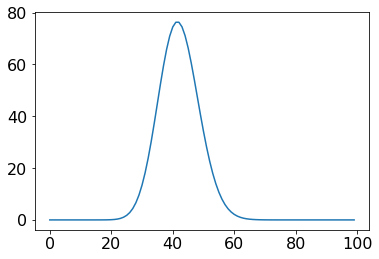

In [39]:
plt.plot(np.arange(100), len(child_to_num_crossovers_mat)*stats.poisson.pmf(np.arange(100), 42))
plt.show()

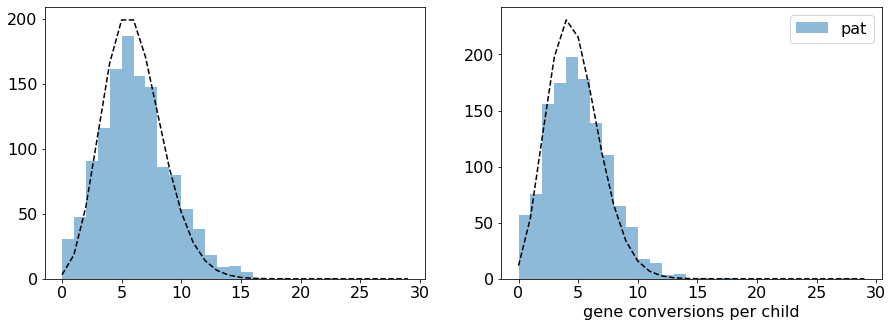

In [62]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(child_to_num_gcs_mat.values(), bins=np.arange(0, 30), alpha=0.5, label='mat')
plt.plot(np.arange(30), len(child_to_num_gcs_mat)*stats.poisson.pmf(np.arange(30), 
                                                                 np.median(list(child_to_num_gcs_mat.values()))), color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(child_to_num_gcs_pat.values(), bins=np.arange(0, 30), alpha=0.5, label='pat')
plt.plot(np.arange(30), len(child_to_num_gcs_mat)*stats.poisson.pmf(np.arange(30), 
                                                                 np.median(list(child_to_num_gcs_pat.values()))), color='black', linestyle='--')
plt.legend()
plt.xlabel('gene conversions per child')

plt.show()

# Check maternal/paternal age at birth

In [9]:
# pull parental ages
child_to_mom_age_at_birth = dict()
child_to_dad_age_at_birth = dict()
with open('../phenotypes/mssng/agre_affchild1.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    mat_age_index = header.index('MATERNAL_AGE_AT_PARTURITION')
    pat_age_index = header.index('PATERNAL_AGE_AT_PARTURITION')
    for pieces in reader:
        if float(pieces[mat_age_index]) > 10:
            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
        if float(pieces[pat_age_index]) > 10:
            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


92 92


In [10]:
with open('../phenotypes/mssng/rmq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    mat_age_index = header.index('MOMAGE')
    pat_age_index = header.index('DADAGE')
    for pieces in reader:
        try:
            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
        except ValueError:
            pass
        try:
            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
        except ValueError:
            pass
print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


244 241


In [11]:
person_to_birthyear = dict()
filenames = ['../phenotypes/ihart/Medical History Mother/MotherH1.csv',
             '../phenotypes/ihart/Medical History Father/FatherH1.csv',
             '../phenotypes/ihart/Medical History Affected Child/AffChild1.csv',
             '../phenotypes/ihart/Medical History Unaffected Child/Unaffec1.csv',
             '../phenotypes/ihart/Language Questionnaire/Language_Questionnaire1.csv',
             '../phenotypes/ihart/Handedness/Hands1.csv',
             '../phenotypes/ihart/AGRE_PhysMeas1.csv',
             '../phenotypes/ihart/AGRE Physical Measurements/AGRE_PhysMeas1.csv',
            ]

for filename in filenames:
    print(filename)
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('age')
        sample_id_index = header.index('Individual ID')
        date_index = header.index('data_entry_date')
        for pieces in reader:
            try:
                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass
            
with open('../phenotypes/mssng/bodymeas.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('AgeN')
    sample_id_index = header.index('Id')
    date_index = header.index('testdate')
    for pieces in reader:
        try:
            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
            person_to_birthyear[pieces[sample_id_index]] = birth_year
        except ValueError:
            pass
        
with open('../phenotypes/mssng/srsadultresearchform.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('SRSAAGE')
    sample_id_index = header.index('Id')
    date_index = header.index('testdate')
    for pieces in reader:
        try:
            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
            person_to_birthyear[pieces[sample_id_index]] = birth_year
        except ValueError:
            pass
        
with open('../phenotypes/mssng/srsparentreportforchild.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('SRSAGE')
    sample_id_index = header.index('Id')
    date_index = header.index('testdate')
    for pieces in reader:
        try:
            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
            person_to_birthyear[pieces[sample_id_index]] = birth_year
        except ValueError:
            pass

filenames = ['../phenotypes/mssng/agre_srs2srs20021.csv',
             '../phenotypes/mssng/agre_srs2006preschool1.csv',
             '../phenotypes/mssng/agre_srs20061.csv',
            ]
for filename in filenames:
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('AGE')
        sample_id_index = header.index('Id')
        date_index = header.index('testdate')
        for pieces in reader:
            try:
                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass

        
filenames = ['../phenotypes/ihart/SRS/SRS_2006_Preschool1.csv',
            '../phenotypes/ihart/SRS/SRS_20061_Adult.csv',
            '../phenotypes/ihart/SRS/SRS_20061_Child.csv',
            '../phenotypes/ihart/SRS/SRS_20061.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021_Child.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021_Preschool.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021.csv'
            ]
for filename in filenames:
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('age')
        sample_id_index = header.index('Individual ID')
        year_index = header.index('InterviewYear')
        month_index = header.index('InterviewMonth')
        day_index = header.index('InterviewDay')
        for pieces in reader:
            try:
                birth_year = (datetime.date(int(pieces[year_index]), int(pieces[month_index]), int(pieces[day_index])) - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass
print(len(person_to_birthyear))


../phenotypes/ihart/Medical History Mother/MotherH1.csv
../phenotypes/ihart/Medical History Father/FatherH1.csv
../phenotypes/ihart/Medical History Affected Child/AffChild1.csv
../phenotypes/ihart/Medical History Unaffected Child/Unaffec1.csv
../phenotypes/ihart/Language Questionnaire/Language_Questionnaire1.csv
../phenotypes/ihart/Handedness/Hands1.csv
../phenotypes/ihart/AGRE_PhysMeas1.csv
../phenotypes/ihart/AGRE Physical Measurements/AGRE_PhysMeas1.csv
8326


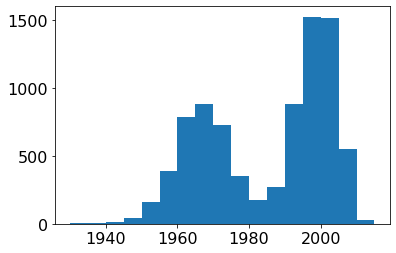

In [12]:
plt.hist(person_to_birthyear.values(), bins=np.arange(1930, 2020, 5))
plt.show()

In [13]:

child_to_mom_age_at_birth, child_to_dad_age_at_birth = dict(), dict()
missing_mom, missing_child = 0, 0
for mom, child in mom_child_pairs:
    if mom in person_to_birthyear and child in person_to_birthyear:
        age_at_birth = person_to_birthyear[child] - person_to_birthyear[mom]
        if age_at_birth > 10 and age_at_birth < 50:
            child_to_mom_age_at_birth[child] = age_at_birth
    elif mom in person_to_birthyear:
        missing_child += 1
    elif child in person_to_birthyear:
        missing_mom += 1
for dad, child in dad_child_pairs:
    if dad in person_to_birthyear and child in person_to_birthyear:
        age_at_birth = person_to_birthyear[child] - person_to_birthyear[dad]
        if age_at_birth > 10 and age_at_birth < 50:
            child_to_dad_age_at_birth[child] = age_at_birth
print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))
print(missing_child, missing_mom)
              

1830 1781
250 11


In [14]:
print(len(child_to_mom_age_at_birth))

print('have ages for ', len(set(child_to_num_crossovers_mat.keys()) & set(child_to_mom_age_at_birth.keys())))
print('missing ages for ', len(set(child_to_num_crossovers_mat.keys()) - set(child_to_mom_age_at_birth.keys())))

1830
have ages for  1044
missing ages for  198


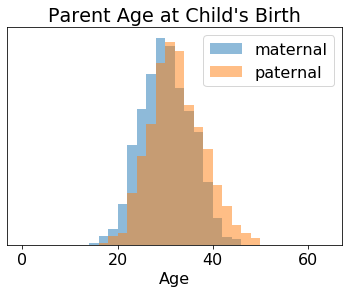

In [15]:
plt.hist(np.clip([child_to_mom_age_at_birth[x] for x in set(child_to_num_crossovers_mat.keys()) if x in child_to_mom_age_at_birth], 0, 64),
        alpha=0.5, bins=np.arange(0, 65, 2), label='maternal')
plt.hist(np.clip([child_to_dad_age_at_birth[x] for x in set(child_to_num_crossovers_mat.keys()) if x in child_to_dad_age_at_birth], 0, 64),
        alpha=0.5, bins=np.arange(0, 65, 2), label='paternal')
plt.title("Parent Age at Child's Birth")
plt.legend()
plt.xlabel('Age')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()


In [19]:
mom_age, mom_recomb, mom_gc = [], [], []
dad_age, dad_recomb, dad_gc = [], [], []
mom_phenotype, dad_phenotype = [], []
mom_family, dad_family = [], []

for child, cross_mat in child_to_num_crossovers_mat.items():
    if child in child_to_mom_age_at_birth:
        mom_age.append(child_to_mom_age_at_birth[child])
        mom_recomb.append(cross_mat)
        mom_gc.append(child_to_num_gcs_mat[child])
        mom_phenotype.append(sample_to_affected[child]=='2')
        
for child, cross_pat in child_to_num_crossovers_pat.items():        
    if child in child_to_dad_age_at_birth:
        dad_age.append(child_to_dad_age_at_birth[child])
        dad_recomb.append(cross_pat)
        dad_gc.append(child_to_num_gcs_pat[child])
        dad_phenotype.append(sample_to_affected[child]=='2')
        
mom_age = np.array(mom_age)
dad_age = np.array(dad_age)
mom_recomb = np.array(mom_recomb)
dad_recomb = np.array(dad_recomb)
mom_gc = np.array(mom_gc)
dad_gc = np.array(dad_gc)
mom_phenotype = np.array(mom_phenotype)
dad_phenotype = np.array(dad_phenotype)
print(mom_age.shape, mom_phenotype.shape)

(1044,) (1044,)


In [20]:

mat_model = sm.GLM(np.array(mom_recomb), np.hstack((mom_age[:, np.newaxis], 
                                                    #mom_phenotype[:, np.newaxis],
                                                    np.ones((mom_age.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:                            GLM   Df Residuals:                     1042
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3820.8
Date:                Mon, 25 Jan 2021   Deviance:                       1846.9
Time:                        11:17:27   Pearson chi2:                 1.86e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0048      0.001      5.271      0.000       0.003       0.007
const          3.5871      0.028    129.712      0.000       3.533       3.641
==============================================================================
"""

In [21]:
mat_results.pvalues

array([1.35461363e-07, 0.00000000e+00])

In [22]:

dad_model = sm.GLM(np.array(dad_recomb), np.hstack((dad_age[:, np.newaxis], 
                                                    #dad_phenotype[:, np.newaxis],
                                                    np.ones((dad_age.shape[0], 1)))), family=Poisson())
dad_results = dad_model.fit()
dad_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1019
Model:                            GLM   Df Residuals:                     1017
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2990.4
Date:                Mon, 25 Jan 2021   Deviance:                       732.11
Time:                        11:17:29   Pearson chi2:                     730.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0008      0.001     -0.746      0.456      -0.003       0.001
const          3.3452      0.034     97.235      0.000       3.278       3.413
==============================================================================
"""

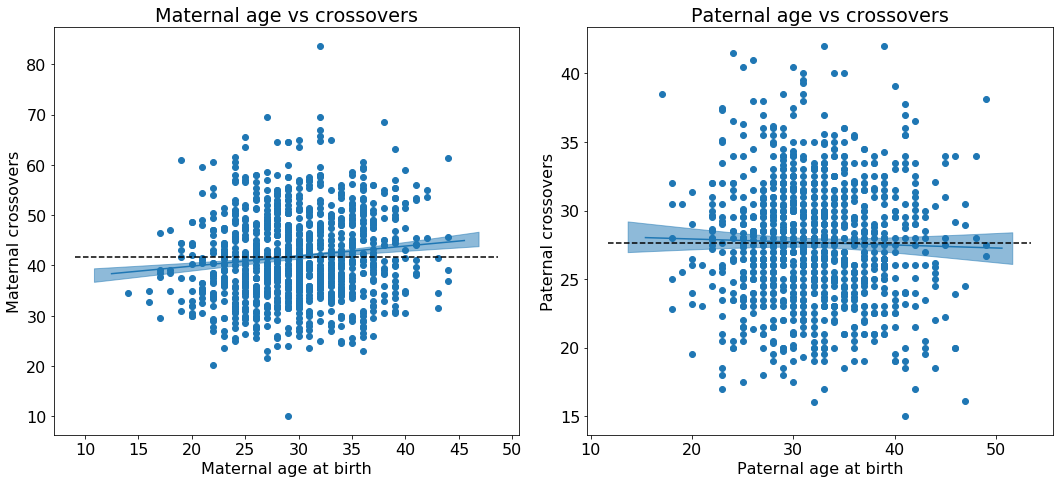

In [23]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(np.array(mom_age), np.array(mom_recomb))
plt.plot(plt.xlim(), np.exp(mat_results.params[1] + mat_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(mom_recomb)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Maternal age at birth')
plt.ylabel('Maternal crossovers')
plt.title('Maternal age vs crossovers')

plt.subplot(1, 2, 2)
plt.scatter(np.array(dad_age), np.array(dad_recomb))
plt.plot(plt.xlim(), np.exp(dad_results.params[1] + dad_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(dad_recomb)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Paternal age at birth')
plt.ylabel('Paternal crossovers')
plt.title('Paternal age vs crossovers')

plt.tight_layout()
plt.show()

In [24]:

mat_model = sm.GLM(np.array(mom_gc), np.hstack((np.array(mom_age)[:, np.newaxis], 
                                                #mom_phenotype[:, np.newaxis],
                                                np.ones((mom_age.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:                            GLM   Df Residuals:                     1042
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2630.6
Date:                Mon, 25 Jan 2021   Deviance:                       1576.8
Time:                        11:17:32   Pearson chi2:                 1.51e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0031      0.002      1.324      0.185      -0.002       0.008
const          1.7187      0.072     23.852      0.000       1.577       1.860
==============================================================================
"""

In [25]:

dad_model = sm.GLM(np.array(dad_gc), np.hstack((np.array(dad_age)[:, np.newaxis], 
                                                #dad_phenotype[:, np.newaxis],
                                                np.ones((dad_age.shape[0], 1)))), family=Poisson())
dad_results = dad_model.fit()
dad_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1019
Model:                            GLM   Df Residuals:                     1017
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2389.1
Date:                Mon, 25 Jan 2021   Deviance:                       1404.9
Time:                        11:17:33   Pearson chi2:                 1.31e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0010      0.002     -0.404      0.686      -0.006       0.004
const          1.6391      0.081     20.231      0.000       1.480       1.798
==============================================================================
"""

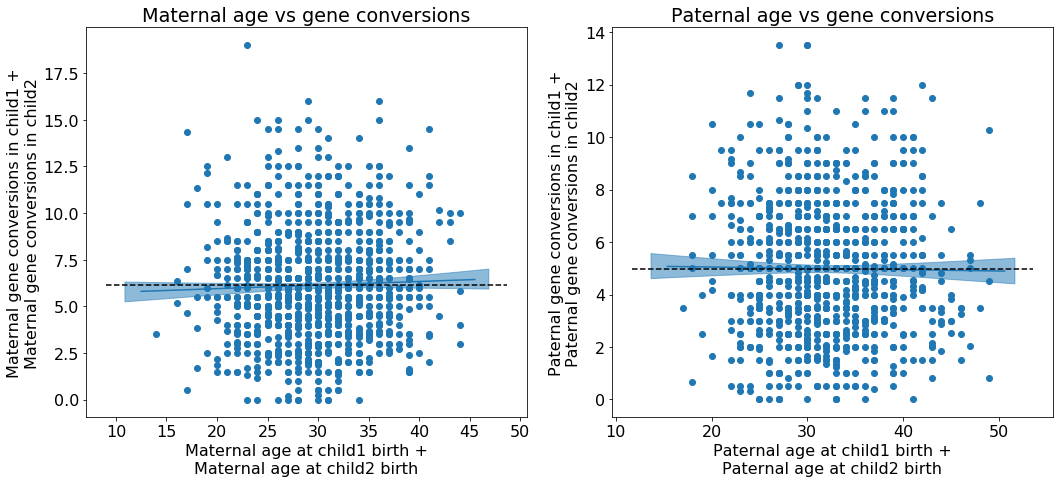

In [26]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(np.array(mom_age), np.array(mom_gc))
plt.plot(plt.xlim(), np.exp(mat_results.params[1] + mat_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(mom_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Maternal age at child1 birth +\nMaternal age at child2 birth')
plt.ylabel('Maternal gene conversions in child1 +\nMaternal gene conversions in child2')
plt.title('Maternal age vs gene conversions')

plt.subplot(1, 2, 2)
plt.scatter(np.array(dad_age), np.array(dad_gc))
plt.plot(plt.xlim(), np.exp(dad_results.params[1] + dad_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(dad_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Paternal age at child1 birth +\nPaternal age at child2 birth')
plt.ylabel('Paternal gene conversions in child1 +\nPaternal gene conversions in child2')
plt.title('Paternal age vs gene conversions')

plt.tight_layout()
plt.show()

In [66]:

mat_model = sm.GLM(np.array(dad_recomb), np.hstack((np.array(mom_recomb)[:, np.newaxis], 
                                                np.ones((mom_gc.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



ValueError: endog and exog matrices are different sizes

In [28]:

pat_model = sm.GLM(np.array(dad_gc), np.hstack((np.array(dad_recomb)[:, np.newaxis], 
                                                np.ones((dad_gc.shape[0], 1)))), family=Poisson())
pat_results = pat_model.fit()
pat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1019
Model:                            GLM   Df Residuals:                     1017
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2389.0
Date:                Mon, 25 Jan 2021   Deviance:                       1404.6
Time:                        11:18:48   Pearson chi2:                 1.31e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0022      0.003     -0.683      0.495      -0.008       0.004
const          1.6663      0.088     18.889      0.000       1.493       1.839
==============================================================================
"""

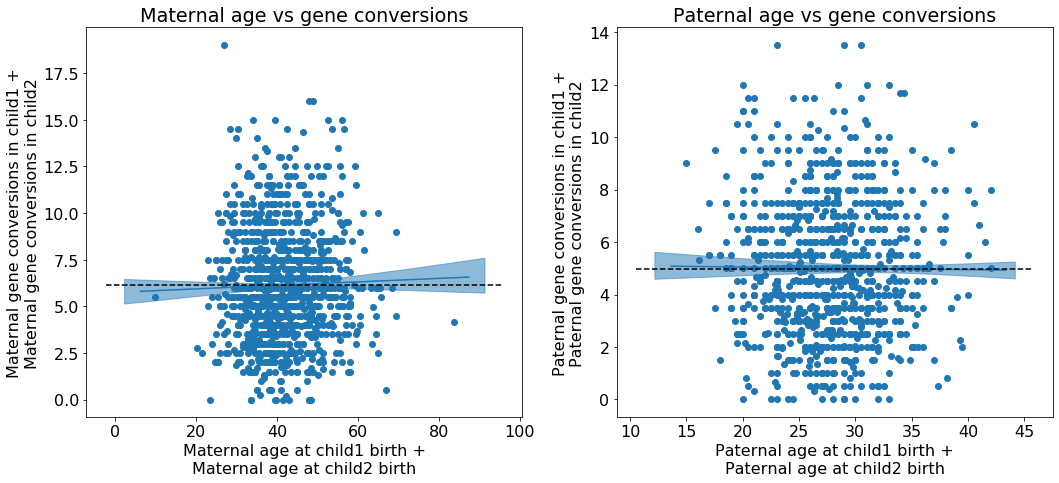

In [29]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(np.array(mom_recomb), np.array(mom_gc))
plt.plot(plt.xlim(), np.exp(mat_results.params[1] + mat_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(mom_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Maternal age at child1 birth +\nMaternal age at child2 birth')
plt.ylabel('Maternal gene conversions in child1 +\nMaternal gene conversions in child2')
plt.title('Maternal age vs gene conversions')

plt.subplot(1, 2, 2)
plt.scatter(np.array(dad_recomb), np.array(dad_gc))
plt.plot(plt.xlim(), np.exp(dad_results.params[1] + dad_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(dad_gc)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Paternal age at child1 birth +\nPaternal age at child2 birth')
plt.ylabel('Paternal gene conversions in child1 +\nPaternal gene conversions in child2')
plt.title('Paternal age vs gene conversions')

plt.tight_layout()
plt.show()

# Any phenotype association?

In [67]:
mat_cross, mat_gc, pat_cross, pat_gc = [], [], [], []
phenotype = []
sex = []

for child, cross_mat in child_to_num_crossovers_mat.items():
    if child in sample_to_affected:
        mat_cross.append(cross_mat)
        mat_gc.append(child_to_num_gcs_mat[child])
        
        pat_cross.append(child_to_num_crossovers_pat[child])
        pat_gc.append(child_to_num_gcs_pat[child])

        phenotype.append(sample_to_affected[child]=='2')
        sex.append(sample_to_sex[child]=='1')

mat_cross = np.array(mat_cross)
mat_gc = np.array(mat_gc)
pat_cross = np.array(pat_cross)
pat_gc = np.array(pat_gc)
phenotype = np.array(phenotype)
sex = np.array(sex)

In [68]:
print(np.sum(phenotype), np.sum(~phenotype))
print(np.sum(sex), np.sum(~sex))

890 352
836 406


In [81]:

mat_model = sm.GLM(mat_gc, np.hstack((sex[:, np.newaxis],
                                      np.ones((mat_cross.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1242
Model:                            GLM   Df Residuals:                     1240
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3161.8
Date:                Tue, 26 Jan 2021   Deviance:                       1948.1
Time:                        11:43:09   Pearson chi2:                 1.86e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0657      0.025      2.659      0.008       0.017       0.114
const          1.7708      0.020     86.487      0.000       1.731       1.811
==============================================================================
"""

In [82]:

mat_model = sm.GLM(pat_gc, np.hstack((sex[:, np.newaxis],
                                      np.ones((mat_cross.shape[0], 1)))), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1242
Model:                            GLM   Df Residuals:                     1240
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2956.3
Date:                Tue, 26 Jan 2021   Deviance:                       1819.8
Time:                        11:43:13   Pearson chi2:                 1.77e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0536      0.027      1.952      0.051      -0.000       0.107
const          1.5642      0.023     68.896      0.000       1.520       1.609
==============================================================================
"""

In [795]:

print(np.sum(phenotype==0), np.sum(phenotype==1))
model = sm.Logit(phenotype, np.hstack((mat_cross[:, np.newaxis],
                                         mat_gc[:, np.newaxis], 
                                         pat_cross[:, np.newaxis], 
                                         pat_gc[:, np.newaxis], 
                                         (sex==1)[:, np.newaxis],
                                         np.ones((phenotype.shape[0], 1)))))
results = model.fit(disp=False)
results.summary()


352 890


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1242
Model:                          Logit   Df Residuals:                     1236
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                 0.06493
Time:                        13:48:19   Log-Likelihood:                -692.34
converged:                       True   LL-Null:                       -740.42
Covariance Type:            nonrobust   LLR p-value:                 3.410e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0034      0.008      0.437      0.662      -0.012       0.018
x2            -0.0536      0.022     -2.412      0.016      -0.097      -0.010
x3            -0.0030      0.015     -0.203      0.839      -0.032       0.026
x4            -0.0610      0.025     -2.408      0.016      -0.111      -0.011
x5             1.2260      0.134      9.134      0.000       0.963       1.489
const          0.7504      0.548      1.369      0.171      -0.324       1.825
==============================================================================
"""

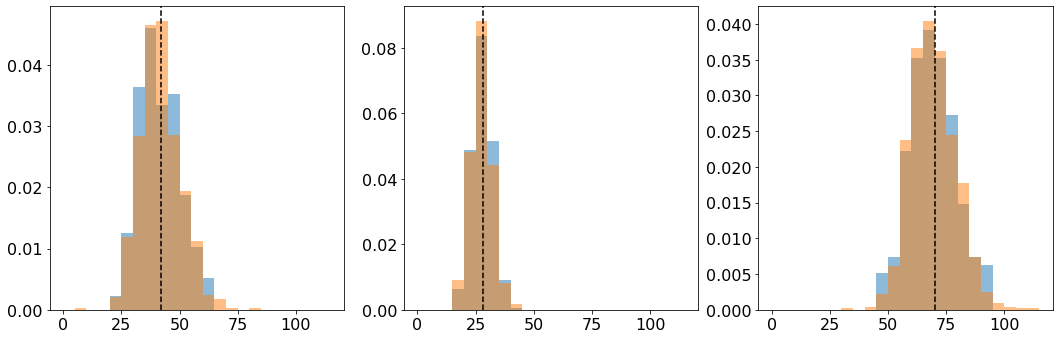

In [796]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 120, 5)

plt.subplot(1, 3, 1)
#plt.violinplot([mat_gc[phenotype==0],
#                mat_gc[phenotype==1],], showmedians=True, showextrema=True)
plt.hist(mat_cross[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1], bins=bins, alpha=0.5, density=True)
plt.axvline(42, color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.hist(pat_cross[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(pat_cross[phenotype==1], bins=bins, alpha=0.5, density=True)
plt.axvline(28, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.hist(mat_cross[phenotype==0]+pat_cross[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1]+pat_cross[phenotype==1], bins=bins, alpha=0.5, density=True)
plt.axvline(42+28, color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [797]:

print(np.sum(phenotype==0), np.sum(phenotype==1))
model = sm.Logit(phenotype, np.hstack((mat_cross[:, np.newaxis]+mat_gc[:, np.newaxis], 
                                       pat_cross[:, np.newaxis]+pat_gc[:, np.newaxis], 
                                         (sex==1)[:, np.newaxis],
                                         np.ones((phenotype.shape[0], 1)))))
results = model.fit(disp=False)
results.summary()


352 890


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1242
Model:                          Logit   Df Residuals:                     1238
Method:                           MLE   Df Model:                            3
Date:                Mon, 18 Jan 2021   Pseudo R-squ.:                 0.05667
Time:                        13:48:20   Log-Likelihood:                -698.45
converged:                       True   LL-Null:                       -740.42
Covariance Type:            nonrobust   LLR p-value:                 4.413e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0042      0.007     -0.590      0.555      -0.018       0.010
x2            -0.0224      0.013     -1.781      0.075      -0.047       0.002
x3             1.1784      0.132      8.907      0.000       0.919       1.438
const          1.1285      0.529      2.133      0.033       0.092       2.165
==============================================================================
"""

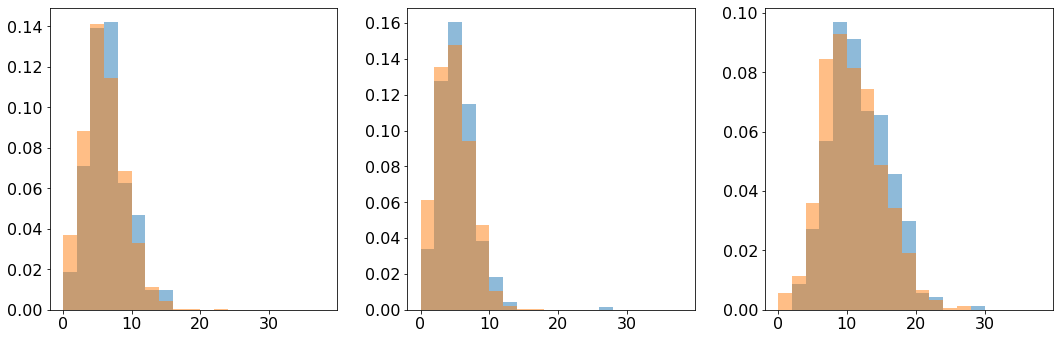

In [798]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 40, 2)

plt.subplot(1, 3, 1)
#plt.violinplot([mat_gc[phenotype==0],
#                mat_gc[phenotype==1],], showmedians=True, showextrema=True)
plt.hist(mat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 2)
plt.hist(pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 3)
plt.hist(mat_gc[phenotype==0]+pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_gc[phenotype==1]+pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.tight_layout()
plt.show()

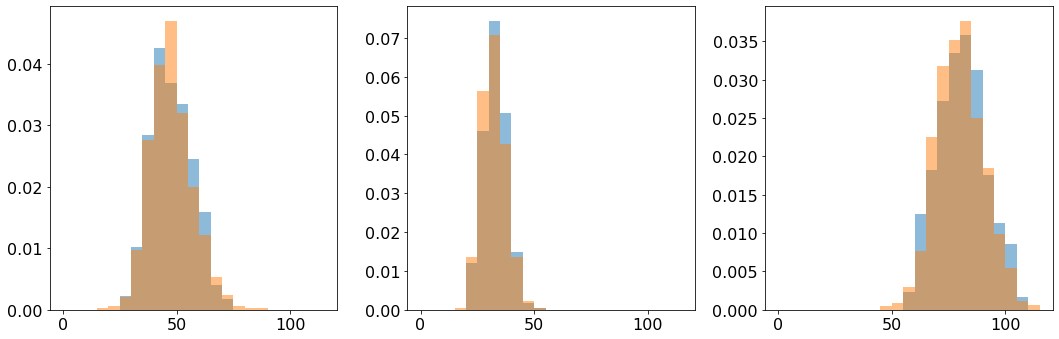

In [800]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 120, 5)

plt.subplot(1, 3, 1)
#plt.violinplot([mat_gc[phenotype==0],
#                mat_gc[phenotype==1],], showmedians=True, showextrema=True)
plt.hist(mat_cross[phenotype==0]+mat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1]+mat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 2)
plt.hist(pat_cross[phenotype==0]+pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(pat_cross[phenotype==1]+pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.subplot(1, 3, 3)
plt.hist(mat_cross[phenotype==0]+pat_cross[phenotype==0]+mat_gc[phenotype==0]+pat_gc[phenotype==0], bins=bins, alpha=0.5, density=True)
plt.hist(mat_cross[phenotype==1]+pat_cross[phenotype==1]+mat_gc[phenotype==1]+pat_gc[phenotype==1], bins=bins, alpha=0.5, density=True)

plt.tight_layout()
plt.show()